In [1]:
import pandas as pd
import igraph
import datetime
import random
import csv
import os
import time

In [2]:
networks = '/Volumes/Data2/RST/notebook/Real Time/networks/'

In [3]:
period = 'MD'

In [4]:
od_data = pd.read_csv('/Volumes/Data2/RST/notebook/TTS OD/TTS_TYPE.csv')
od_data['destination'] = od_data['destination'] + 1000
od_data['origin'] = od_data['origin'] + 1000

In [5]:
if period == 'EM':
    depart_hour = '-4-'
    tts_type = 'raw_em'
if period == 'AM':
    depart_hour = '-7-'
    tts_type = 'raw_am'
elif period =='PM':
    depart_hour = '-17-'
    tts_type = 'raw_pm'
elif period =='MD':
    depart_hour = '-11-'
    tts_type = 'raw_md'
elif period =='EV':
    depart_hour = '-20-'
    tts_type = 'raw_ev'

In [6]:
file_list = os.listdir(networks)
file_list

['2019-11-28_AM.graphml',
 '2019-11-28_AM.csv',
 '2019-11-28_EM.graphml',
 '2019-11-28_EM.csv',
 '2019-11-29_EM.graphml',
 '2019-11-29_EM.csv',
 '2019-12-02_EM.graphml',
 '._2019-11-29_EM.csv',
 '2019-12-02_EM.csv',
 '2019-12-03_EM.graphml',
 '2019-12-03_EM.csv',
 '2019-12-04_EM.graphml',
 '2019-12-04_EM.csv',
 '2019-12-05_EM.graphml',
 '2019-12-05_EM.csv',
 '2019-11-29_AM.graphml',
 '2019-11-29_AM.csv',
 '2019-12-02_AM.graphml',
 '2019-12-02_AM.csv',
 '2019-12-03_AM.graphml',
 '2019-12-03_AM.csv',
 '2019-12-04_AM.graphml',
 '2019-12-04_AM.csv',
 '2019-12-05_AM.graphml',
 '2019-12-05_AM.csv',
 '2019-12-06_AM.graphml',
 '2019-12-06_AM.csv',
 '2019-12-09_AM.graphml',
 '2019-12-06_EM.graphml',
 '2019-12-09_AM.csv',
 '2019-12-06_EM.csv',
 '2019-12-10_AM.graphml',
 '2019-12-09_EM.graphml',
 '2019-12-10_AM.csv',
 '2019-12-09_EM.csv',
 '2019-12-11_AM.graphml',
 '2019-12-10_EM.graphml',
 '2019-12-11_AM.csv',
 '2019-12-10_EM.csv',
 '2019-12-12_AM.graphml',
 '2019-12-11_EM.graphml',
 '2019-12-12

In [7]:
graph_list = []
for file in file_list:
    if file[0] == '.': 
        continue
    if file.split('.')[1] == 'csv':
        continue
    if file.split('_')[1].split('.')[0] == period:
        graph_list.append(file)

In [8]:
graph_list

['2019-11-28_MD.graphml',
 '2019-11-29_MD.graphml',
 '2019-12-02_MD.graphml',
 '2019-12-03_MD.graphml',
 '2019-12-04_MD.graphml',
 '2019-12-05_MD.graphml',
 '2019-12-06_MD.graphml',
 '2019-12-09_MD.graphml',
 '2019-12-10_MD.graphml',
 '2019-12-11_MD.graphml',
 '2019-12-12_MD.graphml',
 '2019-12-13_MD.graphml',
 '2019-12-17_MD.graphml',
 '2019-12-18_MD.graphml',
 '2019-12-19_MD.graphml',
 '2019-12-20_MD.graphml',
 '2019-12-23_MD.graphml',
 '2019-12-27_MD.graphml',
 '2019-12-30_MD.graphml',
 '2020-01-02_MD.graphml',
 '2020-01-03_MD.graphml',
 '2019-11-14_MD.graphml']

In [9]:
graph_list[0].split('_')[0]

'2019-11-28'

In [10]:
iteration = 0
start = time.time()
for graph in graph_list:

    date = graph.split('_')[0]
    
    try:
        print(date, time.time() - start, len(df_out))
    except:
        print(date, time.time() - start)
        
    G = igraph.Graph.Read_GraphML(f = networks + graph)
    
    node_key_table = []
    for i in G.vs:
        node_key_table.append([i.index,  i['id']])
    node_df_new = pd.DataFrame.from_records(node_key_table, columns = ['index', 'node_id'])

    for num_int in range(6):

        minute = random.randint(0,9)
        minute = minute + num_int * 10
        rand_time = depart_hour + str(minute)

        node_data = od_data[od_data['type'] == tts_type][['origin', 'destination']].copy()
        node_data['origin'] = node_data['origin'].astype(str)
        node_data['destination'] = node_data['destination'].astype(str)

        node_data['o_node'] = node_data['origin'] + '-0' + rand_time


        node_data['d_node'] = node_data['destination'] + '-0-99-99'
        node_data = node_data.reset_index()


        node_df_new['INT_ID'] = node_df_new['node_id'].str.split('-', expand = True)[0].astype(int)

        o_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['o_node'])]['index'])
        d_list_new = list(node_df_new[node_df_new['node_id'].isin(node_data['d_node'])]['index'])

        out_all = G.shortest_paths(o_list_new, d_list_new, weights = 'cost',  mode = 'out')

        table = []
        for i in range(len(o_list_new)):
            temp_lst = out_all[i]
            for j in range(len(d_list_new)):
                table.append([o_list_new[i], d_list_new[j], temp_lst[j]])

        temp_df = pd.DataFrame.from_records(table, columns = ['index_o', 'index_d', 'travel_time'])
        temp_df = temp_df.merge(node_df_new[['node_id', 'index', 'INT_ID']], left_on = ['index_o'], right_on = ['index'])
        temp_df = temp_df.rename(columns = {'node_id':'o_node', 'INT_ID':'origin'})[['o_node', 'index_d', 'origin','travel_time']]
        temp_df = temp_df.merge(node_df_new[['node_id', 'index','INT_ID']], left_on = ['index_d'], right_on = ['index'])
        temp_df = temp_df.rename(columns = {'node_id':'d_node','INT_ID':'destination'})[['o_node', 'd_node', 'origin','destination','travel_time']]
        temp_df = temp_df.merge(node_data[['o_node', 'd_node']])
        temp_df = temp_df[temp_df['origin'] != temp_df['destination']]
        temp_df['date'] = date
        temp_df['period'] = period
        temp_df['trial'] = num_int

        if iteration == 0:
            df_out = temp_df.copy()
        else:
            df_out = df_out.append(temp_df).copy()
            
        iteration = iteration + 1
    


2019-11-28 0.0003628730773925781
2019-11-29 343.4913568496704 15108
2019-12-02 679.025486946106 30216
2019-12-03 1020.2002339363098 45324
2019-12-04 1378.4363000392914 60432
2019-12-05 1721.0118429660797 75540
2019-12-06 2061.981791973114 90648
2019-12-09 2397.611053943634 105756
2019-12-10 2733.9421060085297 120864
2019-12-11 3051.4675838947296 135972
2019-12-12 3360.6920828819275 151080
2019-12-13 3688.3439490795135 166188
2019-12-17 4014.0485570430756 181296
2019-12-18 4297.071000099182 196404
2019-12-19 4617.807688951492 211512
2019-12-20 4948.190982103348 226620
2019-12-23 5257.9023978710175 241728
2019-12-27 5559.702407836914 256836
2019-12-30 5840.727639913559 271944
2020-01-02 6142.071868896484 287052
2020-01-03 6436.714562892914 302160
2019-11-14 6735.456928014755 317268


In [12]:
df_out.to_csv('/Volumes/Data2/RST/notebook/Real Time/GE/Results/' + period +'_RT_GE.csv', index = False)

In [13]:
df_out.groupby(['date', 'origin', 'destination']).mean().reset_index().groupby(
    ['date']).sum()[['travel_time']].reset_index().sort_values(by = 'date')

,date,travel_time
0,2019-11-14,114276.833333
1,2019-11-28,128637.666667
2,2019-11-29,130967.333333
3,2019-12-02,125326.333333
4,2019-12-03,128250.500000
5,2019-12-04,129985.666667
6,2019-12-05,130485.000000
7,2019-12-06,129437.500000
8,2019-12-09,127177.666667
9,2019-12-10,130103.166667


<AxesSubplot:>

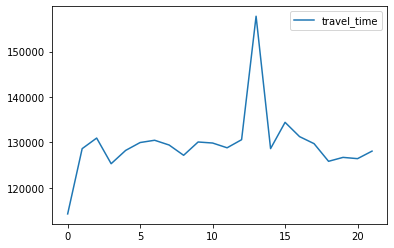

In [14]:
df_out.groupby(['date', 'origin', 'destination']).mean().reset_index().groupby(
    ['date']).sum()[['travel_time']].reset_index().sort_values(by = 'date').plot(y = 'travel_time')